In [1]:
# Download Pancancer-normalized from Xena database:  

# # Example below with TCGA LUAD cohort
!mkdir -p ./data
!curl -o ./data/HiSeqV2_PANCAN_LUAD.gz https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.LUAD.sampleMap%2FHiSeqV2_PANCAN.gz
!gunzip ./data/HiSeqV2_PANCAN_LUAD.gz

# # Download Hallmark genes 
# !curl -L -o ./data/hallmarks_signatures.csv https://raw.githubusercontent.com/mahmoodlab/SurvPath/main/datasets_csv/metadata/hallmarks_signatures.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39.0M  100 39.0M    0     0  3276k      0  0:00:12  0:00:12 --:--:-- 5161k


In [24]:
import pandas as pd 
import os 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# read pan-cancer normalized RNA data from LUAD
df_raw = pd.read_csv('data/HiSeqV2_PANCAN_LUAD', delimiter='\t')

# Hallmark pathways 
hallmarks = pd.read_csv('data/hallmarks_signatures.csv').values.flatten()
hallmarks = hallmarks[~pd.isnull(hallmarks)]
hallmarks = pd.unique(hallmarks)

# Clean provided data
df_clean = pd.read_csv('data_csvs/rna/hallmarks/LUAD/rna_clean.csv', delimiter=',')


In [4]:
folds = [0, 1, 2, 3, 4]
cases_from_folds  = []

for i in folds:
    df2 = pd.read_csv(f'splits/survival/TCGA_LUAD_overall_survival_k={i}/test.csv', delimiter=',')
    df3 = pd.read_csv(f'splits/survival/TCGA_LUAD_overall_survival_k={i}/train.csv', delimiter=',')

    cases_to_keep = list(df2[df2.columns[0]].values.flatten())
    cases_splits3 =list(df3[df3.columns[0]].values.flatten())
    cases_to_keep.extend(cases_splits3)
    print(len(cases_to_keep))
    cases_from_folds.append(set(cases_to_keep))

assert all(s == cases_from_folds[0] for s in cases_from_folds), "Not all sets are the same"

print("All sets in the list are identical.")

463
463
463
463
463
All sets in the list are identical.


In [5]:
print("Nr. of genes in gene sets: ", len(hallmarks))
print("Nr. of patients: ", len(cases_from_folds[0]))

Nr. of genes in gene sets:  4241
Nr. of patients:  412


In [7]:
df_raw_T = df_raw
df_raw_T = df_raw_T.set_index('sample')
df_raw_T = df_raw_T.transpose()
df_raw_T = df_raw_T.sort_index(axis=0)
df_raw_T = df_raw_T.reset_index()

In [8]:
# filter out and transpose
df_raw_filt = df_raw[df_raw['sample'].isin(hallmarks)].reset_index(drop=True)
# print(df_raw_filt)
df_raw_filt = df_raw_filt.rename(columns={'sample': None})
df_raw_filt = df_raw_filt.set_index(None)
# print(df_raw_filt)
df_raw_filt = df_raw_filt.transpose()
# print(df_raw_filt)
df_raw_filt = df_raw_filt.sort_index(axis=0)
# # print(df_raw_filt)
df_raw_filt = df_raw_filt.reset_index()
# print(df_raw_filt)
df_raw_filt = df_raw_filt.rename(columns={'index': 'sample'})
# print(df_raw_filt)
# Drop the samples from the normal tissue
df_filtered = df_raw_filt[~df_raw_filt['sample'].str.endswith('-11')].reset_index(drop=True)

# Keep only the samples from the primary tissue
df_filtered['sample'] = df_filtered['sample'].str.replace(r'-01', '', regex=True)

# Keep only the samples from the splits files; samples used in training
df_filtered_complete = df_filtered[df_filtered['sample'].isin(cases_to_keep)].reset_index(drop=True)

In [9]:
num_rows_raw, num_cols_raw = df_raw.shape
num_rows_raw_T, num_cols_raw_T = df_raw_T.shape
num_rows_filt, num_cols_filt = df_filtered_complete.shape
num_rows_clean, num_cols_clean = df_clean.shape

# -1 to leave out the column displaying the samples
assert num_cols_raw_T - 1 == num_rows_raw
assert num_cols_raw - 1 == num_rows_raw_T

In [10]:
print(f"Number of samples raw: {num_rows_raw_T}")
print(f"Number of genes raw: {num_cols_raw_T - 1}")

print(f"Number of samples filtered: {num_rows_filt}")
print(f"Number of genes filtered: {num_cols_filt - 1}")

print(f"Number of samples clean: {num_rows_clean}")
print(f"Number of genes clean: {num_cols_clean - 1}")

Number of samples raw: 576
Number of genes raw: 20530
Number of samples filtered: 412
Number of genes filtered: 4168
Number of samples clean: 576
Number of genes clean: 1022


In [14]:
df_clean_no_dupl = df_clean[df_clean['Unnamed: 0'].isin(cases_to_keep)].reset_index(drop=True)
df_clean_no_dupl = df_clean_no_dupl[~df_clean_no_dupl['Unnamed: 0'].duplicated()].reset_index(drop=True)

print(df_clean_no_dupl)

num_rows_clean2, num_cols_clean2 = df_clean_no_dupl.shape

print(f"Number of samples clean: {num_rows_clean2}")
print(f"Number of genes clean: {num_cols_clean2 - 1}")


       Unnamed: 0       A2M      AAAS     AADAT      ABAT     ABCA1     ABCA2  \
0    TCGA-69-7978  1.251923 -0.529402 -0.042641 -0.630948  1.379942  0.748904   
1    TCGA-78-7539  0.904123 -0.288402  0.149659 -1.503948 -0.165658 -0.706396   
2    TCGA-50-5931  2.681523 -0.972402  0.333659 -1.544748  1.744042 -1.117096   
3    TCGA-73-4658  2.265523 -1.073002 -1.748941 -1.465748  0.553142 -1.016396   
4    TCGA-44-6775  0.443723 -0.784002  0.855459 -0.463548  0.603842 -0.358696   
..            ...       ...       ...       ...       ...       ...       ...   
407  TCGA-86-8358 -0.141477 -0.149102  1.614959 -1.647348 -0.980558 -0.601496   
408  TCGA-55-7727  1.028323 -1.278202  1.057759 -0.080448  1.168042 -2.314796   
409  TCGA-MN-A4N4  0.766923 -0.153902  0.806759  0.344752  0.234242 -0.002596   
410  TCGA-55-8302  0.393523  0.145198 -0.341541 -2.544348  0.342342 -0.726296   
411  TCGA-MP-A4TK  1.020823 -0.097502 -0.198641 -1.482548 -0.169758  0.314804   

       ABCA3     ABCA4     

In [22]:
excluded_genes = []
for col in df_filtered_complete.columns.values:
    if col in df_clean_no_dupl.columns.values:
        continue
    else:
        excluded_genes.append(col)


print(excluded_genes)
print(len(excluded_genes))

['sample', 'RNF11', 'PMM2', 'NCBP1', 'RBM14', 'NCBP2', 'SPR', 'ZNF707', 'ZC3H14', 'TCOF1', 'NUP98', 'XPC', 'SLC12A2', 'GRINA', 'NUP93', 'OPA1', 'RAB40C', 'SPPL2A', 'TGFBR2', 'ITGA9', 'ITGA2', 'ITGA3', 'ITGA4', 'ITGA5', 'ITGA6', 'ITGA7', 'SWAP70', 'PHLDA3', 'PHLDA2', 'PMM1', 'SQLE', 'THSD4', 'NOG', 'ITGAV', 'HIBCH', 'ITGAL', 'ITGAM', 'SERPING1', 'LRPAP1', 'SMAD6', 'SMAD7', 'SMAD1', 'SMAD3', 'IGF2R', 'TCEA1', 'TCP1', 'SPHK1', 'IFT88', 'IL10RA', 'SP1', 'PDIA5', 'PNP', 'PNN', 'SIDT1', 'SERPINA10', 'SIDT2', 'SYNJ1', 'VPS37D', 'UQCRC2', 'XPNPEP1', 'VPS37B', 'DPYSL3', 'IGFBP2', 'IGFBP3', 'IGFBP1', 'IGFBP7', 'IGFBP4', 'IGFBP5', 'SKP2', 'STMN1', 'KDM3A', 'PKLR', 'PRKAR2A', 'TXNIP', 'MLF1', 'RIT1', 'P2RX7', 'HAS2', 'MYBL1', 'ITGB1BP1', 'ITGB1BP2', 'PHLDA1', 'ZAP70', 'OGFR', 'RAC2', 'RAC1', 'RCL1', 'ERGIC3', 'PER1', 'UXT', 'DLGAP5', 'PLK3', 'PLK2', 'HRH1', 'DNAJA1', 'TGFBR3', 'DNAJA4', 'PTPN11', 'PTPN14', 'LYAR', 'DMD', 'MSMB', 'TIPARP', 'RELA', 'LPAR6', 'MYO1E', 'MYO1C', 'NDC80', 'SRI', 'SRM', '

In [36]:
overlapping_genes_df = df_filtered_complete.drop(columns=excluded_genes[1:])
print(overlapping_genes_df)

           sample      ATRX      ASS1     CAMK4    COL7A1  ATP2A1    ATP2A2  \
0    TCGA-05-4249  0.104797  1.625351 -1.046298 -1.852148  0.2727  0.564543   
1    TCGA-05-4382 -0.276103 -0.231249 -0.667198  0.260052  1.3493  0.444943   
2    TCGA-05-4398 -0.297403  2.921251 -0.355698 -0.500548  0.3925  0.152943   
3    TCGA-05-4402  0.123197  1.189951 -0.726698  0.030052 -0.7398  0.381743   
4    TCGA-05-4403 -0.883303  2.675751 -0.307198 -0.785948 -2.3234 -0.127457   
..            ...       ...       ...       ...       ...     ...       ...   
407  TCGA-NJ-A55O -0.116103  2.768551 -0.478798 -0.868548 -0.9664 -0.214557   
408  TCGA-NJ-A55R -0.113703  0.901851  0.172102  2.547752  0.6820  0.735643   
409  TCGA-NJ-A7XG  0.620397  0.628551 -1.930298 -0.725648  1.1155  0.184343   
410  TCGA-O1-A52J  1.015097 -0.300749 -0.536898 -2.585048  1.9128 -0.566157   
411  TCGA-S2-AA1A  0.645197  0.549851  2.024402  0.632352  1.0946 -0.403157   

        CHST8    COL4A2   COL4A1  ...     ABCC3    

In [23]:
excluded_genes_df = df_filtered_complete[excluded_genes]
print(excluded_genes_df)

           sample     RNF11      PMM2     NCBP1     RBM14     NCBP2       SPR  \
0    TCGA-05-4249  0.011822  0.676442 -0.030605 -0.076321 -0.574271  0.845306   
1    TCGA-05-4382  0.131822 -0.013758 -0.165605 -0.347121 -0.276871  0.388506   
2    TCGA-05-4398 -0.269378  0.853442  0.309395  0.129679 -0.114771  0.532406   
3    TCGA-05-4402  0.817822  0.555042 -0.154005  0.109579  0.164229  0.791306   
4    TCGA-05-4403  0.297422 -0.254958  0.046395 -0.215321 -0.753971  1.491806   
..            ...       ...       ...       ...       ...       ...       ...   
407  TCGA-NJ-A55O -0.553178  1.233142  0.113195 -0.219321 -0.677471  0.220806   
408  TCGA-NJ-A55R -0.382578  0.742342  0.444895  0.222779 -0.212971  0.473006   
409  TCGA-NJ-A7XG -0.589278  0.341842 -0.510205 -0.107321 -0.254171  0.639006   
410  TCGA-O1-A52J -0.831078  0.204342 -0.327005  0.022079 -0.153071  0.391106   
411  TCGA-S2-AA1A -0.320778  0.758742 -0.657405 -0.358121 -0.242371  0.925506   

       ZNF707    ZC3H14    

In [78]:
print(df_own_sorted.iloc[36, 1])
print(df_own_sorted.iloc[20, 0])

print(df_prov_sorted.iloc[36, 1])
print(df_prov_sorted.iloc[20, 0])

-0.138077300039
TCGA-38-4625
3.46772269996
TCGA-38-4625


In [62]:
df_own_sorted = overlapping_genes_df.rename(columns={'sample': 'Unnamed: 0'})[df_clean_no_dupl.columns.values]
df_prov_sorted = df_clean_no_dupl.sort_values(by='Unnamed: 0').reset_index().drop(columns='index')

pd.testing.assert_frame_equal(df_own_sorted, df_prov_sorted)


AssertionError: DataFrame.iloc[:, 1] (column name="A2M") are different

DataFrame.iloc[:, 1] (column name="A2M") values are different (5.82524 %)
[index]: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]
[left]:  [1.32372269996, 1.18322269996, 0.320822699961, 0.988822699961, 1.66292269996, 1.64432269996, -1.41957730004, 1.73282269996, 0.256522699961, 0.0408226999609, 2.46282269996, -0.488177300039, 0.254022699961, 1.90042269996, 0.551122699961, 1.76052269996, -0.0186773000391, 0.387822699961, -0.647377300039, -0.418077300039, 0.212322699961, 2.92722269996, -0.112177300039, 0.335222699961, -1.78027730004, -1.23787730004, -0.369377300039, 1.52572269996, 3.31322269996, 1.92332269996, 1.24202269996, 1.46362269996, 2.21142269996, 1.85082269996, 1.36952269996, -0.228177300039, -0.138077300039, 2.20722269996, -0.103177300039, 0.693922699961, 1.14442269996, 0.683922699961, 1.56402269996, 0.264622699961, -1.35027730004, -0.971177300039, 2.22312269996, 1.31932269996, 1.03102269996, 2.30722269996, 3.80852269996, 1.97432269996, 0.443722699961, 1.51112269996, 2.84662269996, 2.37922269996, 0.440922699961, 0.221322699961, -0.916677300039, 1.88292269996, 0.800222699961, -0.837777300039, 0.842422699961, -0.172977300039, 1.50442269996, 1.29982269996, 0.315222699961, 0.660822699961, -0.315777300039, -0.0222773000391, 1.47232269996, 0.865022699961, 0.605722699961, 0.813022699961, 1.30602269996, -0.573877300039, 1.71622269996, 0.941422699961, -0.903177300039, 0.865622699961, 0.556922699961, -0.170077300039, 0.815922699961, 1.09902269996, 1.97542269996, 1.23102269996, -0.955577300039, -1.69797730004, -0.340477300039, 1.32222269996, -0.558977300039, 0.189322699961, -0.340177300039, -2.08977730004, -0.395977300039, 0.828922699961, -2.21167730004, 2.40252269996, -1.26607730004, 0.507322699961, ...]
[right]: [1.32372269996, 1.18322269996, 0.320822699961, 0.988822699961, 1.66292269996, 1.64432269996, -1.41957730004, 1.73282269996, 0.256522699961, 0.0408226999609, 2.46282269996, -0.488177300039, 0.254022699961, 1.90042269996, 0.551122699961, 1.76052269996, -0.0186773000391, 0.387822699961, -0.647377300039, -0.418077300039, 0.212322699961, 2.92722269996, -0.112177300039, 0.335222699961, -1.78027730004, -1.23787730004, -0.369377300039, 1.52572269996, 3.31322269996, 1.92332269996, 1.24202269996, 1.46362269996, 2.73392269996, 1.85082269996, 1.36952269996, -0.228177300039, 3.46772269996, 2.20722269996, -0.103177300039, 3.37792269996, 1.14442269996, 0.683922699961, 1.56402269996, 0.264622699961, -1.35027730004, -0.971177300039, 2.78422269996, 1.31932269996, 1.03102269996, 3.03912269996, 3.48902269996, 1.97432269996, 0.443722699961, 1.51112269996, 2.84662269996, 2.37922269996, 0.440922699961, 0.221322699961, -0.916677300039, 1.88292269996, 0.800222699961, -0.837777300039, 0.842422699961, -0.172977300039, 1.50442269996, 1.29982269996, 0.315222699961, 0.660822699961, -0.315777300039, -0.0222773000391, 1.47232269996, 0.865022699961, 0.605722699961, 0.813022699961, 1.30602269996, -0.573877300039, 1.71622269996, 0.941422699961, -0.903177300039, 0.865622699961, 2.32172269996, -0.170077300039, 0.815922699961, 3.51932269996, 1.97542269996, 2.17822269996, -0.955577300039, -1.69797730004, -0.340477300039, 1.32222269996, -0.558977300039, 0.189322699961, -0.340177300039, -2.08977730004, -0.395977300039, 0.828922699961, -2.21167730004, 2.40252269996, -1.26607730004, 0.507322699961, ...]
At positional index 32, first diff: 2.21142269996 != 2.73392269996

In [32]:
#Boxplot per gene
def plot_box_per_gene(df_provided, r1=1, r2=6):

    # Transpose to have genes in rows and samples in columns
    df_provided_per_gene = df_provided.iloc[:, r1:r2]

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_provided_per_gene)
    plt.title("Distribution of Expression Values per Excluded Gene")
    plt.xlabel("Samples")
    plt.ylabel("Expression Value")
    plt.xticks(rotation=45)
    plt.show()

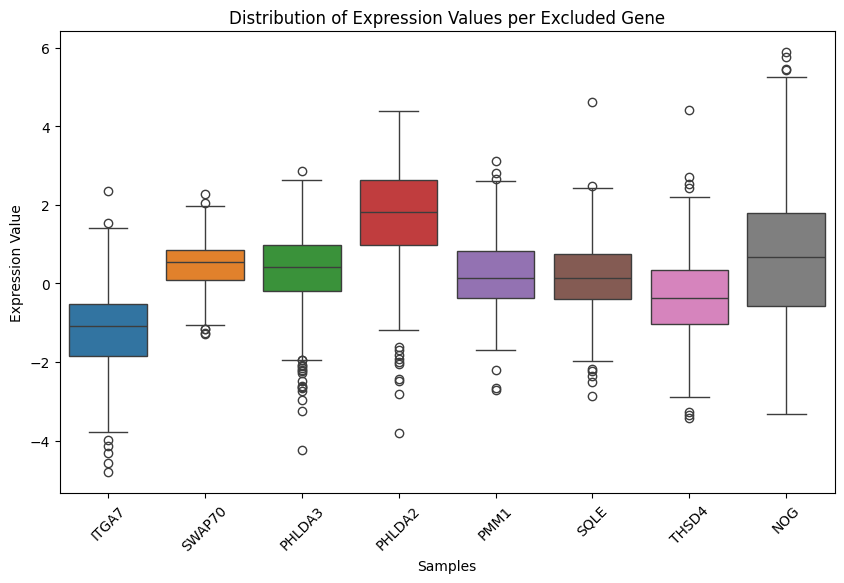

In [81]:
plot_box_per_gene(excluded_genes_df, 25, 33)

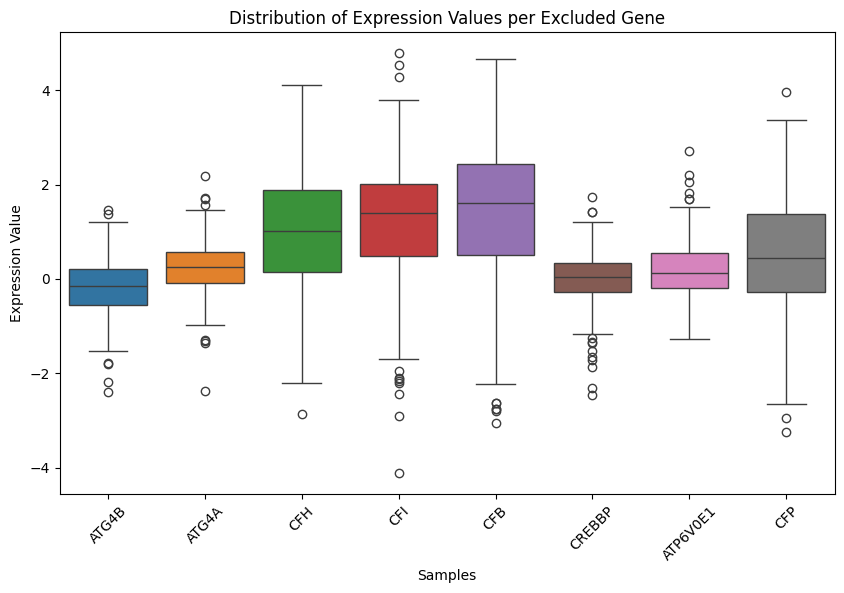

In [79]:
plot_box_per_gene(overlapping_genes_df, 25, 33)

In [76]:
#Boxplot per sample
def plot_box_per_sample(df_provided, df_downloaded, r1=30, r2=37):

    # Transpose to have genes in rows and samples in columns
    df_provided_per_sample = df_provided.iloc[r1: r2,:].T.drop("Unnamed: 0", axis=0)
    # df_downloaded_per_sample = df_downloaded.head(5)
    print(" FOR DATA THET PROVIDED")
    print("Mean: ", df_provided_per_sample.mean(axis=0))
    print("Std: ", df_provided_per_sample.std(axis=0))

    # plt.figure(figsize=(10, 6))
    # sns.boxplot(data=df_provided_per_sample)
    # plt.title("Distribution of Expression Values per Sample")
    # plt.xlabel("Samples")
    # plt.ylabel("Expression Value")
    # plt.xticks(rotation=45)
    # plt.show()

    # Transpose to have genes in rows and samples in columns
    df_downloaded_per_sample = df_downloaded.iloc[r1:r2,:].T.drop("Unnamed: 0", axis=0)
    print(" FOR DATA THET PROVIDED")
    print("Mean: ", df_downloaded_per_sample.mean(axis=0))
    print("Std: ", df_downloaded_per_sample.std(axis=0))

    # plt.figure(figsize=(10, 6))
    # sns.boxplot(data=df_downloaded_per_sample)
    # plt.title("Distribution of Expression Values per Sample")
    # plt.xlabel("Samples")
    # plt.ylabel("Expression Value")
    # plt.xticks(rotation=45)
    # plt.show()

In [77]:
plot_box_per_sample(df_own_sorted, df_prov_sorted)


 FOR DATA THET PROVIDED
Mean:  30    0.359412
31    0.433651
32    0.515046
33    0.272483
34    0.525834
35    0.249756
36    0.318363
dtype: object
Std:  30    1.568914
31    1.537114
32    1.420973
33    1.352713
34    1.573259
35    1.564937
36     1.45716
dtype: object
 FOR DATA THET PROVIDED
Mean:  30    0.359412
31    0.433651
32    0.540873
33    0.272483
34    0.525834
35    0.249756
36     0.32941
dtype: object
Std:  30    1.568914
31    1.537114
32    1.632834
33    1.352713
34    1.573259
35    1.564937
36    1.638919
dtype: object
